In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# data analysis and wrangling
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
from ipywidgets import interact
import joblib
import shap
shap.initjs()
import warnings
import lightgbm as lgb
import pickle
# machine learning 
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,learning_curve
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,classification_report,make_scorer,f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import MyClassAndFun as MCF

In [2]:
df=pd.read_csv('transformed__dumm_train.csv')
df.drop(['id','customer_id','month','ssn_aaa','monthly_inhand_salary','delay_from_due_date'], axis=1, inplace=True)#,
       #  'num_credit_card','interest_rate'], axis=1, inplace=True)
X=df.drop('credit_score', axis=1)
y=df['credit_score']
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.1, random_state=1,stratify=y)
from sklearn.preprocessing import PowerTransformer
pt=PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
transform_var_list=['age','annual_income','changed_credit_limit',#'delay_from_due_date',,'interest_rate'
                    'credit_utilization_ratio','credit_history_monts',#'outstanding_debt',
                    'num_of_delayed_payment','total_emi_per_month','amount_invested_monthly','monthly_balance',]
for i in transform_var_list:
    X_train[i]=pt.fit_transform(X_train[[i]])
    X_test[i]=pt.transform(X_test[[i]])
X_train_df=pd.DataFrame(X_train,columns=X.columns)
X_test_df=pd.DataFrame(X_test,columns=X.columns)
combined_df = pd.concat([X_train_df, y_train], axis=1)
test_results = MCF.perform_tests(combined_df)
# print(test_results.sort_values(by="t-statistic", ascending=False))
X_test_df=X_test_df[list(test_results.loc[test_results['p-value']==0].column)]
X_train_df=X_train_df[list(test_results.loc[test_results['p-value']==0].column)]

In [3]:
class_labels = np.unique(y)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train)
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(unique, counts))

In [4]:
parameters = {'penalty':  ['l1', 'l2', 'elasticnet', None],
              'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
              'max_iter':[100,500,1000,1500,2000],
              'multi_class': ['auto', 'ovr', 'multinomial']}

lr_classifier = LogisticRegression(n_jobs=-1)
lr_cv = GridSearchCV(lr_classifier, parameters, cv= 10)

lr_cv.fit(X_train_df, y_train)
print(f"Best parameters for knn_cv: {lr_cv.best_params_}")
print(f"Best F1-score for knn_cv: {lr_cv.best_score_}")         

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
'n_jobs' > 1 does not have any effect when 'solver' is set t

Best parameters for knn_cv: {'max_iter': 100, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'newton-cg'}
Best F1-score for knn_cv: 0.6559777777777778


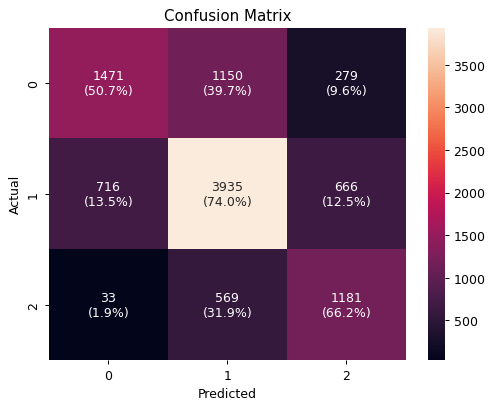

Classification Report for K-Nearest Neighbors Classification:

              precision    recall  f1-score   support

           0       0.66      0.51      0.57      2900
           1       0.70      0.74      0.72      5317
           2       0.56      0.66      0.60      1783

    accuracy                           0.66     10000
   macro avg       0.64      0.64      0.63     10000
weighted avg       0.66      0.66      0.66     10000



In [8]:
# parameters= {'max_iter': 100, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'newton-cg'}
lr_classifier = LogisticRegression(max_iter=100,multi_class= 'auto', penalty='l2', solver= 'newton-cg')  # ovr - one-vs-rest
lr_classifier.fit(X_train_df, y_train)

# Saving model
# joblib.dump(KNN_C, 'KNN_C_model.joblib')
# Loading the model back
# KNN_C = joblib.load('KNN_C_model.joblib')

lr_classifier_pred = lr_classifier.predict(X_test_df)
confusion = confusion_matrix(y_test, lr_classifier_pred)
report = classification_report(y_test, lr_classifier_pred)

cm = confusion_matrix(y_test, lr_classifier_pred)
cm_norm = confusion_matrix(y_test,lr_classifier_pred, normalize="true")
annot = np.array([f"{i}\n({g:.1%})" for i, g in zip(cm.flatten(), cm_norm.flatten())])
annot = annot.reshape(cm.shape)
fig = plt.figure(dpi=90)
sns.heatmap(cm, annot=annot, fmt="", xticklabels=lr_classifier.classes_, yticklabels=lr_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()

# Print the classification report
print(f"Classification Report for K-Nearest Neighbors Classification:\n")
print(report)

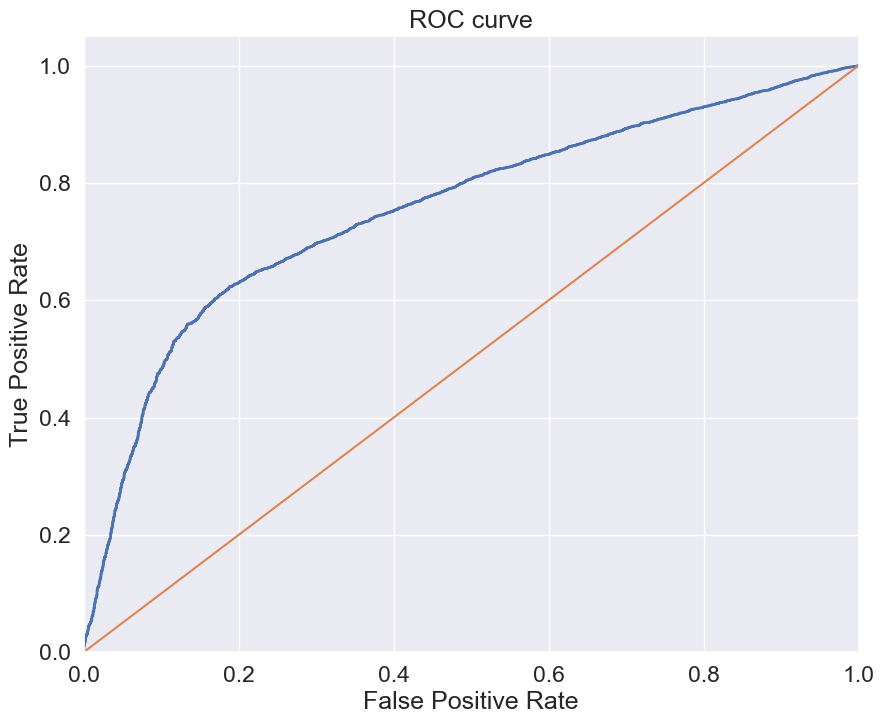

In [11]:
MCF.ROC_curve(lr_classifier,X_test_df,y_test)

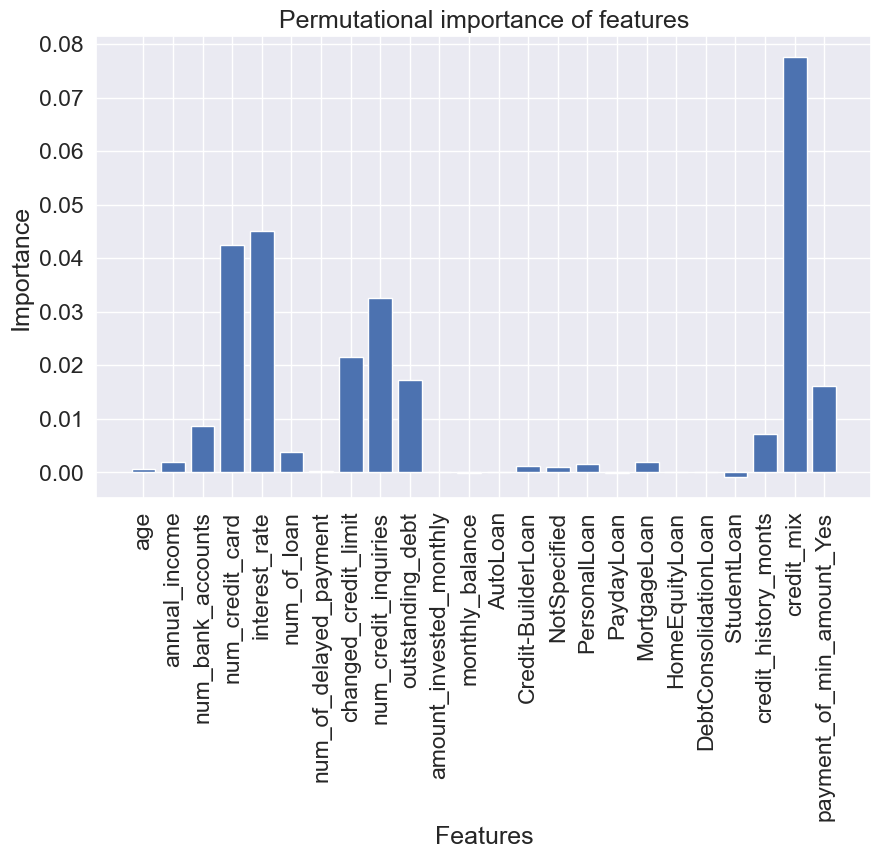

In [12]:
MCF.Perm_import(lr_classifier,X_test_df,y_test)

Rounding errors prevent the line search from converging
The line search algorithm did not converge
Line Search failed


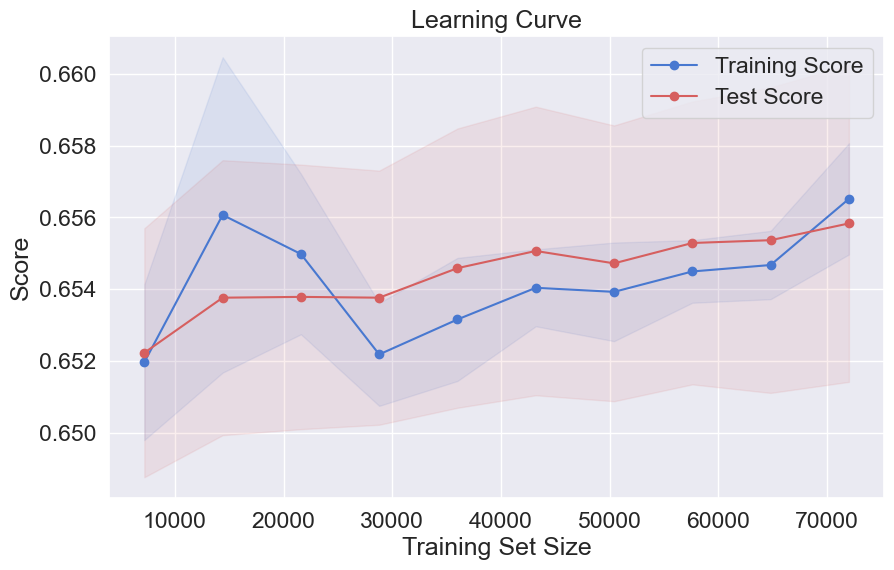

In [13]:
train_sizes = np.linspace(0.1, 1.0, 10)  
MCF.plot_learning_curve(lr_classifier, X_train_df, y_train, X_test_df, y_test, train_sizes)